# Management Hierarchy Example

This example demonstrates self-referencing tables and hierarchical data structures, showing how to model organizational relationships where employees manage other employees. It also showcases the benefits of using lookup tables for normalized data design.

## Database Schema

The database consists of four tables:
1. **Department** - A lookup table containing department information (codes, names, budgets, locations)
2. **Employee** - Individual employees with basic information and department assignment
3. **ReportsTo** - An association table linking employees to their managers
4. **DepartmentChair** - A table linking departments to their chairs

This design allows:
- Each employee to have at most one manager (many-to-one relationship)
- Each manager to have multiple direct reports (one-to-many relationship)
- Each employee to belong to exactly one department (many-to-one relationship)
- Each department to have exactly one chair (one-to-one relationship)
- Each employee to be chair of at most one department (one-to-zero-or-one relationship)
- Modeling of organizational hierarchies with normalized department data
- Extended department metadata (budget, location) without data duplication


In [52]:
%xmode minimal
import datajoint as dj

# Create schema
schema = dj.Schema('management_example')

Exception reporting mode: Minimal


## Table Definitions


In [53]:
@schema
class Department(dj.Lookup):
    definition = """
    dept_code : char(3)  # Department code (e.g., 'ENG', 'MKT', 'SAL')
    ---
    department_name : varchar(50)  # Full department name
    location : varchar(30)  # Office location
    """
    contents = [
        ('ENG', 'Engineering','Building A'),
        ('MKT', 'Marketing', 'Building B'),
        ('SAL', 'Sales', 'Building C'),
        ('HR', 'Human Resources', 'Building A'),
        ('FIN', 'Finance', 'Building A'),
    ]

@schema
class Employee(dj.Manual):
    definition = """
    employee_id : int  # Unique identifier for each employee
    ---
    name : varchar(60)  # Employee's name
    -> Department 
    hire_date : date  # When they were hired
    """


In [54]:
@schema
class ReportsTo(dj.Manual):
    definition = """
    -> Employee
    ---
    -> Employee.proj(manager_id='employee_id')
    """

@schema
class DepartmentChair(dj.Manual):
    definition = """
    -> Department
    ---
    -> [unique]Employee
    appointed_date : date  # When they became department char
    """


## Populating the Database

Let's create a realistic organizational hierarchy with sample data.


In [55]:
# Insert employees with realistic hierarchy using Department lookup table
employee_data = [
    # Top-level executives
    {'employee_id': 1, 'name': 'Alice Johnson', 'dept_code': 'ENG', 'hire_date': '2015-01-15'},
    {'employee_id': 2, 'name': 'Bob Smith', 'dept_code': 'MKT', 'hire_date': '2016-03-20'},
    
    # Mid-level managers
    {'employee_id': 3, 'name': 'Carol Davis', 'dept_code': 'ENG', 'hire_date': '2017-06-10'},
    {'employee_id': 4, 'name': 'David Wilson', 'dept_code': 'ENG', 'hire_date': '2018-02-14'},
    {'employee_id': 5, 'name': 'Eva Brown', 'dept_code': 'MKT', 'hire_date': '2018-09-05'},
    
    # Individual contributors
    {'employee_id': 6, 'name': 'Frank Miller', 'dept_code': 'ENG', 'hire_date': '2019-04-12'},
    {'employee_id': 7, 'name': 'Grace Lee', 'dept_code': 'ENG', 'hire_date': '2019-07-18'},
    {'employee_id': 8, 'name': 'Henry Taylor', 'dept_code': 'ENG', 'hire_date': '2020-01-08'},
    {'employee_id': 9, 'name': 'Ivy Chen', 'dept_code': 'MKT', 'hire_date': '2020-03-25'},
    {'employee_id': 10, 'name': 'Jack Anderson', 'dept_code': 'SAL', 'hire_date': '2020-06-30'},
]

Employee.insert(employee_data)
print(f"Inserted {len(employee_data)} employees")

# Display Department lookup table
print("\nDepartment lookup table:")
print(Department())


Inserted 10 employees

Department lookup table:
*dept_code    department_nam location      
+-----------+ +------------+ +------------+
ENG           Engineering    Building A    
FIN           Finance        Building A    
HR            Human Resource Building A    
MKT           Marketing      Building B    
SAL           Sales          Building C    
 (Total: 5)



In [56]:
# Create reporting relationships
reports_data = [
    # Alice Johnson (1) manages Carol Davis (3) and David Wilson (4)
    {'employee_id': 3, 'manager_id': 1},  # Carol reports to Alice
    {'employee_id': 4, 'manager_id': 1},  # David reports to Alice
    
    # Bob Smith (2) manages Eva Brown (5)
    {'employee_id': 5, 'manager_id': 2},  # Eva reports to Bob
    
    # Carol Davis (3) manages Frank Miller (6) and Grace Lee (7)
    {'employee_id': 6, 'manager_id': 3},  # Frank reports to Carol
    {'employee_id': 7, 'manager_id': 3},  # Grace reports to Carol
    
    # David Wilson (4) manages Henry Taylor (8)
    {'employee_id': 8, 'manager_id': 4},  # Henry reports to David
    
    # Eva Brown (5) manages Ivy Chen (9)
    {'employee_id': 9, 'manager_id': 5},  # Ivy reports to Eva
    
    # Jack Anderson (10) has no manager (top-level in Sales)
]


In [57]:

ReportsTo.insert(reports_data)

# Create department chair   s
department_chairs_data = [
    {'dept_code': 'ENG', 'employee_id': 1, 'appointed_date': '2015-01-15'},  # Alice Johnson heads Engineering
    {'dept_code': 'MKT', 'employee_id': 2, 'appointed_date': '2016-03-20'},  # Bob Smith heads Marketing
    {'dept_code': 'SAL', 'employee_id': 10, 'appointed_date': '2020-06-30'}, # Jack Anderson heads Sales
    {'dept_code': 'HR', 'employee_id': 11, 'appointed_date': '2021-01-15'},  # We'll add HR head
    {'dept_code': 'FIN', 'employee_id': 12, 'appointed_date': '2021-02-01'}, # We'll add Finance head
]

# Add the missing employees for HR and Finance chairs
additional_employees = [
    {'employee_id': 11, 'name': 'Sarah Wilson', 'dept_code': 'HR', 'hire_date': '2020-08-15'},
    {'employee_id': 12, 'name': 'Michael Brown', 'dept_code': 'FIN', 'hire_date': '2020-09-01'},
]

Employee.insert(additional_employees)
DepartmentChair.insert(department_chairs_data)


## Database Diagram

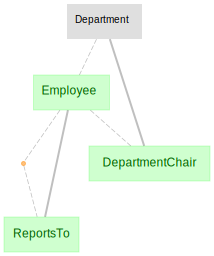

In [58]:
dj.Diagram(schema)


## Hierarchical Queries

Now let's explore various queries that demonstrate hierarchical data analysis.


In [59]:
# Query 1: Show information about department chairs

Employee & DepartmentChair 

employee_id Unique identifier for each employee,name Employee's name,"dept_code Department code (e.g., 'ENG', 'MKT', 'SAL')",hire_date When they were hired
1,Alice Johnson,ENG,2015-01-15
2,Bob Smith,MKT,2016-03-20
10,Jack Anderson,SAL,2020-06-30
11,Sarah Wilson,HR,2020-08-15
12,Michael Brown,FIN,2020-09-01


In [60]:
# Query 2: Show department info including the names of their chairs

(Department * DepartmentChair.proj() * Employee.proj(chair='name'))

"dept_code Department code (e.g., 'ENG', 'MKT', 'SAL')",employee_id Unique identifier for each employee,department_name Full department name,location Office location,chair Employee's name
ENG,1,Engineering,Building A,Alice Johnson
ENG,2,Engineering,Building A,Bob Smith
ENG,3,Engineering,Building A,Carol Davis
ENG,4,Engineering,Building A,David Wilson
ENG,5,Engineering,Building A,Eva Brown
ENG,6,Engineering,Building A,Frank Miller
ENG,7,Engineering,Building A,Grace Lee
ENG,8,Engineering,Building A,Henry Taylor
ENG,9,Engineering,Building A,Ivy Chen
ENG,10,Engineering,Building A,Jack Anderson


In [61]:
# Query 2: Show information for managers (employees who have others reporting to them)
Employee.proj(..., manager_id='employee_id') & ReportsTo


manager_id Unique identifier for each employee,name Employee's name,"dept_code Department code (e.g., 'ENG', 'MKT', 'SAL')",hire_date When they were hired
1,Alice Johnson,ENG,2015-01-15
2,Bob Smith,MKT,2016-03-20
3,Carol Davis,ENG,2017-06-10
4,David Wilson,ENG,2018-02-14
5,Eva Brown,MKT,2018-09-05


In [62]:
# Query 3: Show top managers, i.e. employees who do not have managers
Employee - ReportsTo

employee_id Unique identifier for each employee,name Employee's name,"dept_code Department code (e.g., 'ENG', 'MKT', 'SAL')",hire_date When they were hired
1,Alice Johnson,ENG,2015-01-15
2,Bob Smith,MKT,2016-03-20
10,Jack Anderson,SAL,2020-06-30
11,Sarah Wilson,HR,2020-08-15
12,Michael Brown,FIN,2020-09-01


In [63]:
# Query 4: Show individual contributors, i.e. employees who do not have any direct reports 

# Re-interpretation: show all employees whose employee_id does not appear 
# in the manager_id column of the ReportsTo table
Employee - ReportsTo.proj(employee_id='manager_id', x='employee_id')

employee_id Unique identifier for each employee,name Employee's name,"dept_code Department code (e.g., 'ENG', 'MKT', 'SAL')",hire_date When they were hired
6,Frank Miller,ENG,2019-04-12
7,Grace Lee,ENG,2019-07-18
8,Henry Taylor,ENG,2020-01-08
9,Ivy Chen,MKT,2020-03-25
10,Jack Anderson,SAL,2020-06-30
11,Sarah Wilson,HR,2020-08-15
12,Michael Brown,FIN,2020-09-01


In [64]:
# Query 5: Show middle managers

Employee & ReportsTo & ReportsTo.proj(employee_id='manager_id', x='employee_id')

employee_id Unique identifier for each employee,name Employee's name,"dept_code Department code (e.g., 'ENG', 'MKT', 'SAL')",hire_date When they were hired
3,Carol Davis,ENG,2017-06-10
4,David Wilson,ENG,2018-02-14
5,Eva Brown,MKT,2018-09-05


In [65]:
# Show all employees and the number of direct reports they have
Employee.proj(..., manager_id='employee_id').aggr(
    ReportsTo, ..., direct_reports='count(employee_id)', 
    keep_all_rows=True)


manager_id Unique identifier for each employee,name Employee's name,"dept_code Department code (e.g., 'ENG', 'MKT', 'SAL')",hire_date When they were hired,direct_reports calculated attribute
1,Alice Johnson,ENG,2015-01-15,2
2,Bob Smith,MKT,2016-03-20,1
3,Carol Davis,ENG,2017-06-10,2
4,David Wilson,ENG,2018-02-14,1
5,Eva Brown,MKT,2018-09-05,1
6,Frank Miller,ENG,2019-04-12,0
7,Grace Lee,ENG,2019-07-18,0
8,Henry Taylor,ENG,2020-01-08,0
9,Ivy Chen,MKT,2020-03-25,0
10,Jack Anderson,SAL,2020-06-30,0
